In [1]:
from conf import *
from ydata_profiling import ProfileReport
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from functools import wraps
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import KernelDensity
import contextily as cx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Data loading and preprocessing

In [2]:
#Set the path of the data rather than in local.
base= Path('.')
DATA_DIR = base / "data" / "clean"
DATA_DIR.mkdir(parents=True, exist_ok=True)
#The Airbnb data
DATA_URL = "https://orca.casa.ucl.ac.uk/~jreades/data/20250615-London-listings.csv.gz"
DATA_PATH = DATA_DIR / "20250615-London-listings.csv.gz"


In [3]:
#Wrap the download data function with the decorato, and
#download the Airbnb data.
def check_cache(f):
    @wraps(f)
    def wrapper(src, dest):
        dest = Path(dest)
        if dest.exists() and dest.is_file():
            print(f"{dest} found locally!")
            return dest
        else:
            print(f"{dest} not found, downloading!")
            return f(src, dest)
    return wrapper

@check_cache
def download_data(src, dest):
    dest = Path(dest)
    dest.parent.mkdir(parents=True, exist_ok=True)
    response = urlopen(src)
    with dest.open("wb") as f:
        f.write(response.read())
    print(f"Data written to {dest}!")
    return dest

def load_listings():
    local_path = download_data(DATA_URL, DATA_PATH)
    return pd.read_csv(local_path)

# print a few for test.
df = load_listings()
df.head()

data/clean/20250615-London-listings.csv.gz found locally!


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,264776,https://www.airbnb.com/rooms/264776,20250610032232,2025-06-11,city scrape,Huge Four Bedroom Apartment,An extremely large and sunny four bedroom grou...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.74,4.62,4.72,NaN,t,11,11,0,0,0.51
1,264777,https://www.airbnb.com/rooms/264777,20250610032232,2025-06-11,city scrape,One Bedroom Apartment,Recently refurbished sunny one bedroom first f...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.25,4.54,4.42,NaN,t,11,11,0,0,0.22
2,264778,https://www.airbnb.com/rooms/264778,20250610032232,2025-06-11,city scrape,Two Bedroom Newly Refurbished Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50662093/af12...,1389063,...,4.52,4.36,4.38,NaN,t,11,11,0,0,0.43
3,264779,https://www.airbnb.com/rooms/264779,20250610032232,2025-06-11,city scrape,Refurbished Two Bedroom Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50660860/e440...,1389063,...,4.61,4.50,4.47,NaN,t,11,11,0,0,0.30
4,264780,https://www.airbnb.com/rooms/264780,20250610032232,2025-06-11,city scrape,Spacious refurbished 2 bedroom apt with balcony,Completely refurbished 2 bedroom apt to sleep ...,NaN,https://a0.muscache.com/pictures/airflow/Hosti...,1389063,...,4.74,4.37,4.59,NaN,t,11,11,0,0,0.35


In [4]:
#Set the path of spatial data
SPATIAL_DIR = base / 'data' / 'spatial'
SPATIAL_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
#make a function to download the spatial data
def download_spatial(src_url, filename):
    dest = SPATIAL_DIR / filename
    if dest.exists():
        print(f"{filename} found locally!")
        return dest
    
    print(f"Downloading {filename}...")
    response = urlopen(src_url)
    with open(dest, 'wb') as f:
        f.write(response.read())
    print(f"Saved to {dest}")
    
    return dest

#the url of every spatial data
RAW_URLS = {
    "boroughs": "https://raw.githubusercontent.com/jreades/fsds/master/data/src/Boroughs.gpkg",
    "water": "https://raw.githubusercontent.com/jreades/fsds/master/data/src/Water.gpkg",
    "greenspace": "https://raw.githubusercontent.com/jreades/fsds/master/data/src/Greenspace.gpkg",
    "msoa": "https://orca.casa.ucl.ac.uk/~jreades/data/MSOA-2011.gpkg",
    "msoa_names": "https://houseofcommonslibrary.github.io/msoanames/MSOA-Names-1.20.csv",
}

In [6]:
# Download all spatial files defined in RAW_URLS
local_paths = {}  # store downloaded paths

for key, url in RAW_URLS.items():
    filename = url.split("/")[-1]  # extract file name from URL
    local_path = download_spatial(url, filename)
    local_paths[key] = local_path  # store for later use

Boroughs.gpkg found locally!
Water.gpkg found locally!
Greenspace.gpkg found locally!
MSOA-2011.gpkg found locally!
MSOA-Names-1.20.csv found locally!


In [7]:
#define every spatial data
boroughs = gpd.read_file(local_paths["boroughs"])
msoa_origin = gpd.read_file(local_paths["msoa"])
greenspace = gpd.read_file(local_paths["greenspace"])
msoa_names = pd.read_csv(local_paths["msoa_names"])
water= gpd.read_file(local_paths["water"])

Because the main analysis is based on price, property type, number of listings from the landlord, and number of bookable nights, we are doing some data cleaning on that.

In [8]:
#Here are some data cleaning of Airbnb data
#remove special character in price
df['price'] = (df['price'].astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
        .replace("", None)
        .astype(float)
    )

#remove invalid prices
df = df[df['price'] > 0].copy()

#keep valid availability range
df = df[df['availability_365'].between(0, 365)]

#drop listings without spatial coordinates
df = df.dropna(subset=['latitude', 'longitude'])
#fill missing host listing count
df['host_total_listings_count'] = df['host_total_listings_count'].fillna(1)
#because there are some extreme luxury house, may set a cap on price.
df = df[df['price'] < 2000] #2000 maybe a proper price cap..

In [9]:
#merge the msoa data and msoa names
msoa = msoa_origin.merge(
    msoa_names,
    left_on="MSOA11CD",
    right_on="msoa11cd",
    how="left"
)

In order to prepare for the future further analysis, transform the Airbnb data from df to gdf, check the crs, and then join with the msoa.

In [10]:
#Read info about the msoa
#msoa.head()
msoa.crs

<Projected CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [11]:
#Convert listings DataFrame to points
gdf_listings = gpd.GeoDataFrame(df,
                                geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
                                crs="EPSG:4326")

#find if need to reproject listings to match msoa crs
if msoa.crs is not None and gdf_listings.crs != msoa.crs:
    gdf_listings = gdf_listings.to_crs(msoa.crs)

gdf_listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
0,264776,https://www.airbnb.com/rooms/264776,20250610032232,2025-06-11,city scrape,Huge Four Bedroom Apartment,An extremely large and sunny four bedroom grou...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.62,4.72,NaN,t,11,11,0,0,0.51,POINT (537739.117 173423.255)
1,264777,https://www.airbnb.com/rooms/264777,20250610032232,2025-06-11,city scrape,One Bedroom Apartment,Recently refurbished sunny one bedroom first f...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,4.54,4.42,NaN,t,11,11,0,0,0.22,POINT (537705.727 173397.87)
2,264778,https://www.airbnb.com/rooms/264778,20250610032232,2025-06-11,city scrape,Two Bedroom Newly Refurbished Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50662093/af12...,1389063,...,4.36,4.38,NaN,t,11,11,0,0,0.43,POINT (537510.287 173476.053)
3,264779,https://www.airbnb.com/rooms/264779,20250610032232,2025-06-11,city scrape,Refurbished Two Bedroom Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50660860/e440...,1389063,...,4.50,4.47,NaN,t,11,11,0,0,0.30,POINT (537486.78 173470.967)
4,264780,https://www.airbnb.com/rooms/264780,20250610032232,2025-06-11,city scrape,Spacious refurbished 2 bedroom apt with balcony,Completely refurbished 2 bedroom apt to sleep ...,NaN,https://a0.muscache.com/pictures/airflow/Hosti...,1389063,...,4.37,4.59,NaN,t,11,11,0,0,0.35,POINT (537488.831 173446.54)


In [12]:
#show msoa columns
print(msoa.columns)

Index(['MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM',
       'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ',
       'geometry', 'msoa11cd', 'msoa11nm', 'msoa11nmw', 'msoa11hclnm',
       'msoa11hclnmw', 'Laname'],
      dtype='object')


In [13]:
#Keep only geometry and MSOA identifiers for the join
msoa_1 = msoa[['MSOA11CD', 'MSOA11NM', 'geometry']]

#left join them
listings_msoa = gpd.sjoin(gdf_listings,msoa_1,how='left',predicate='within')

listings_msoa.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,index_right,MSOA11CD,MSOA11NM
0,264776,https://www.airbnb.com/rooms/264776,20250610032232,2025-06-11,city scrape,Huge Four Bedroom Apartment,An extremely large and sunny four bedroom grou...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,t,11,11,0,0,0.51,POINT (537739.117 173423.255),654.0,E02000677,Lewisham 025
1,264777,https://www.airbnb.com/rooms/264777,20250610032232,2025-06-11,city scrape,One Bedroom Apartment,Recently refurbished sunny one bedroom first f...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,1389063,...,t,11,11,0,0,0.22,POINT (537705.727 173397.87),654.0,E02000677,Lewisham 025
2,264778,https://www.airbnb.com/rooms/264778,20250610032232,2025-06-11,city scrape,Two Bedroom Newly Refurbished Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50662093/af12...,1389063,...,t,11,11,0,0,0.43,POINT (537510.287 173476.053),649.0,E02000672,Lewisham 020
3,264779,https://www.airbnb.com/rooms/264779,20250610032232,2025-06-11,city scrape,Refurbished Two Bedroom Apartment,A large and sunny two bedroom second floor apa...,Catford is a well established London suburb. T...,https://a0.muscache.com/pictures/50660860/e440...,1389063,...,t,11,11,0,0,0.30,POINT (537486.78 173470.967),649.0,E02000672,Lewisham 020
4,264780,https://www.airbnb.com/rooms/264780,20250610032232,2025-06-11,city scrape,Spacious refurbished 2 bedroom apt with balcony,Completely refurbished 2 bedroom apt to sleep ...,NaN,https://a0.muscache.com/pictures/airflow/Hosti...,1389063,...,t,11,11,0,0,0.35,POINT (537488.831 173446.54),649.0,E02000672,Lewisham 020


In [14]:
#Ensure availability_365 and price are numeric
listings_msoa['availability_365'] = pd.to_numeric(listings_msoa['availability_365'])
listings_msoa['price'] = pd.to_numeric(listings_msoa['price'])

In [15]:
#drop rows where MSOA11CD is missing (outside London polygons)
listings_msoa = listings_msoa.dropna(subset=['MSOA11CD'])

# 1.Is Airbnb “Out of Control” in London

To assess whether Airbnb in London is experiencing "over control", we may say some illegal renting or pricing may causing over control. 

In [16]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

as_markdown('1.1 90-days rule', "There is a 90 days regulation(also known as short-let regulation)(@90_day_rule), Short-term rentals are permitted for a maximum of 90 days a year, exceeding this period requires a special permit.  so are the Airbnb hosts against this policy will be a perspect.")

##### 1.1 90-days rule

>There is a 90 days regulation(also known as short-let regulation)(@90_day_rule), Short-term rentals are permitted for a maximum of 90 days a year, exceeding this period requires a special permit.  so are the Airbnb hosts against this policy will be a perspect.


**Assumption**

We assumed that the availability_365 level of listings could be used as an indicator of the intensity of short-term rental activity. When a listing shows availability above 90 days, it could indicate a policy violation or evidence that the host is operating a professional rental business, rather than as a casual home-sharer.


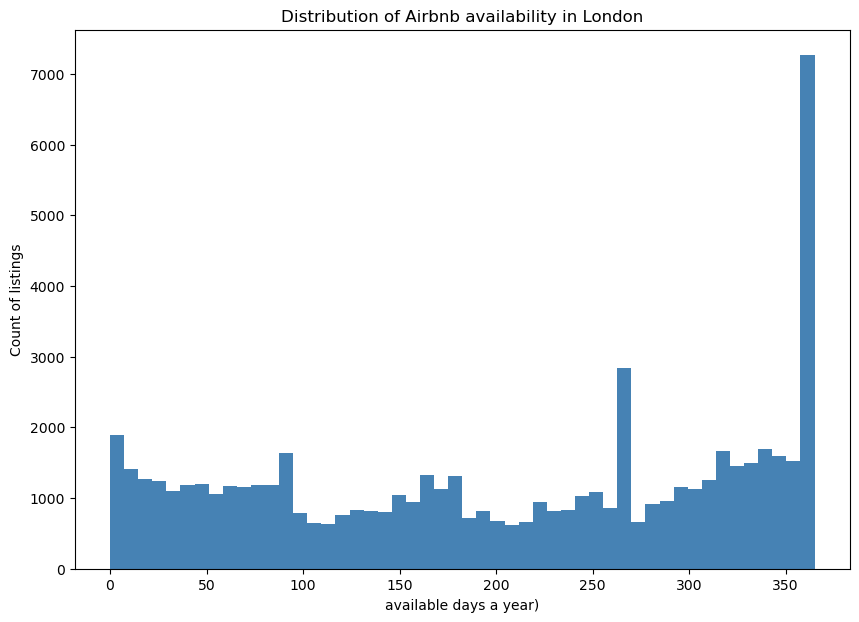

In [17]:
#The availability_365 distribution can indicate 
#whether Airbnb in London is a "seasonal short-term rental" 
#(low availability) or a "year-round operation" 
#(high availability).

# Plot distribution of availability_365
plt.figure(figsize=(10, 7))
plt.hist(df['availability_365'], bins=50, color='steelblue')
plt.xlabel("available days a year)")
plt.ylabel("Count of listings")
plt.title("Distribution of Airbnb availability in London")
plt.show()

In [18]:
#availability_365 > 90 is a potential key element
#of illegal hosting. 

#count the number of listing over 90, 180 and 300.
over_90 = (df['availability_365'] > 90)
over_180 = (df['availability_365'] > 180)
over_300 = (df['availability_365'] > 300)

print(f"Share of listings available > 90 days: {over_90.mean():.2%}")
print(f"Share of listings available > 180 days: {over_180.mean():.2%}")
print(f"Share of listings available > 300 days: {over_300.mean():.2%}")

Share of listings available > 90 days: 73.86%
Share of listings available > 180 days: 55.83%
Share of listings available > 300 days: 30.33%


In [19]:
# Compare availability patterns across room types
room_groups = df.groupby('room_type')['availability_365']

over_90_by_room = room_groups.apply(lambda x: (x > 90).mean())
print("Share of >90-day listings by room type:")
print((over_90_by_room * 100).round(2).astype(str) + "%")

Share of >90-day listings by room type:
room_type
Entire home/apt    73.72%
Hotel room         79.41%
Private room       74.01%
Shared room        87.21%
Name: availability_365, dtype: object


Based on this quantitative data, these proportions suggest that the majority of listings are potentially 
non-compliant with short-let regulations and are managed like business units.

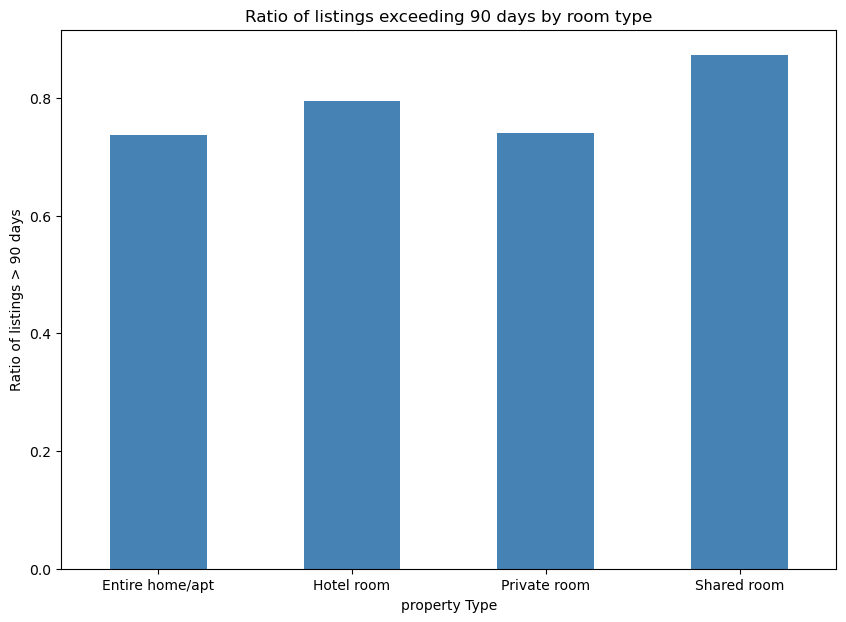

In [20]:
#plot ratio of property type >90
ax = over_90_by_room.plot(kind='bar', figsize=(10, 7), color='steelblue')
ax.set_xlabel("property Type")
ax.set_ylabel("Ratio of listings > 90 days")
ax.set_title("Ratio of listings exceeding 90 days by room type")
plt.xticks(rotation=0)
plt.show()

When we compared this pattern by property type, the entire home/apartment category had an availability rate of >90 days at 73.72%. Categories like hotel rooms and shared rooms even showed higher rates, indicating the presence of quasi-hotels and multi-room operators operating through the platform. This finding corresponds with the study conducted by @shabrina_airbnb_2022, which identified that Airbnb misused in London was prevalent in entire homes in areas with a high private rental stock.

<Figure size 800x500 with 0 Axes>

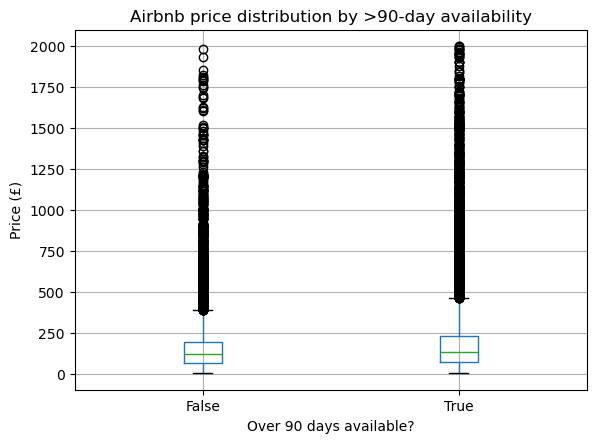

In [21]:
#Also can look at the price level of those over 90 days a year.
df['over_90'] = df['availability_365'] > 90

plt.figure(figsize=(8, 5))
df.boxplot(column='price', by='over_90')
plt.title("Airbnb price distribution by >90-day availability")
plt.suptitle("")
plt.xlabel("Over 90 days available?")
plt.ylabel("Price (£)")
plt.show()

Listings operating for more than 90 days tend to have higher prices than compliant listings, with many outliers reaching £1,000–£2,000 per night. Theoretically, this behavior is compatible with the study of @barron_effect_2021, who explained that Airbnb's expansion is driving a shift in residential units from the long-term to the short-term rental markets, causing pressure on rental prices and house sales.

**Conclusion**

Overall, based on our analysis of listing availability data, the proportion of listings exceeding the 90-day limit, variations in patterns across property types, and commercial rental signals, we conclude that Airbnb activity in London exhibits characteristics of being “out of control.” The platform is no longer dominated by house host renting units occasionally but by professional operators running large-scale short-term rental businesses which has the potential to reduce long-term housing availability and tighten the city’s housing market.

**Limitation**

We acknowledge that availability_365 does not directly measure occupancy and may overestimate regulatory non-compliance if hosts block calendars for non-rental reasons. However, the consistency of signals across availability, property type, and price distributions increases confidence that the observed patterns reflect structural market behaviour rather than data artefacts. Our conclusions should therefore be interpreted as indicative of scale and direction, rather than precise estimates of illegality.


In [22]:
as_markdown('1.2 Price level','Price level of Airbnb in London is another key aspect to indicate if airbnb out of control.')

##### 1.2 Price level

>Price level of Airbnb in London is another key aspect to indicate if airbnb out of control.


**Assumption**

We use price level as a complementary indicator of whether Airbnb activity in London has shifted away from casual home-sharing toward commercial operation. The underlying assumption is that consistently high nightly prices are more likely to be associated with professionally managed, investment-oriented properties than with residents occasionally renting spare rooms.


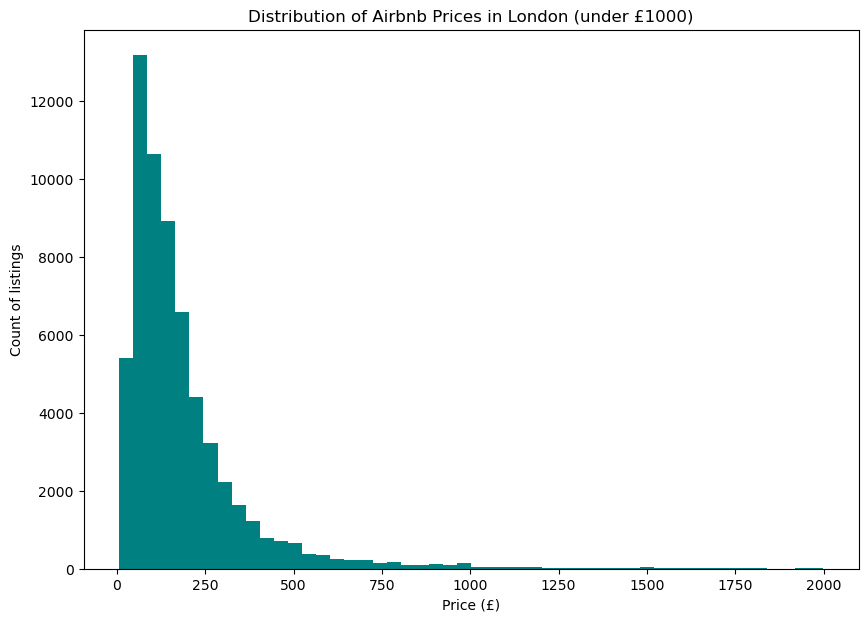

In [23]:
#Plot distribution of Airbnb prices
plt.figure(figsize=(10, 7))
plt.hist(df['price'], bins=50, color='teal')
plt.xlabel("Price (£)")
plt.ylabel("Count of listings")
plt.title("Distribution of Airbnb Prices in London (under £1000)")
plt.show()

In [24]:
#Look at some statistics on price
print("Price summary statistics:")
print(df['price'].describe())

Price summary statistics:
count    62445.000000
mean       185.369541
std        185.407696
min          6.000000
25%         75.000000
50%        134.000000
75%        224.000000
max       1999.000000
Name: price, dtype: float64


Based on statistics, the average price was around £185 per night, with a median of £134, but the highest price was £1,999, demonstrating significant price inequality. To determine the extent to which Airbnb activity has evolved away from its original goal of home-sharing, we set a “high” price threshold of more than £200 per night. The results show that 29.38% of listings are priced above £200, a significant proportion for a market that is supposedly dominated by non-commercial short-term rentals.

In [25]:
#We set a price level that ober 200 a night 
#could be "higher than usual", It may deviate from 
#Airbnb's original purpose.

high_price = df['price'] > 200
print(f"Share of listings priced > £200: {high_price.mean():.2%}")
#Shows price over 200 by room type.
high_price_by_type = df.groupby('room_type')['price'].apply(lambda x: (x > 200).mean())
print("\nShare of >£200 listings by room type:")
print((high_price_by_type * 100).round(2).astype(str) + "%")


Share of listings priced > £200: 29.38%

Share of >£200 listings by room type:
room_type
Entire home/apt    41.32%
Hotel room         41.18%
Private room        4.13%
Shared room         5.81%
Name: price, dtype: object


When these findings are disaggregated by property type, the pattern of commercialization becomes clearer. Entire home/apartment listings have the highest proportion in the high-price category with approximately 41.32% of these units are priced above £200 per night. This is significant because this property type is the type that has the potential to reduce the supply of long-term rentals when transferred to the Airbnb market. In contrast, private and shared rooms have a considerably smaller proportion of expensive properties, which suggest that commercialization is mostly driven by units with higher economic worth.

In [26]:
#Combine with the 90 days rule, count the ratio that
#satisfy over 200 a night and 90 a year.
df['over_90'] = df['availability_365'] > 90
df['high_price'] = df['price'] > 200
df['high_high'] = df['over_90'] & df['high_price']

print(f"Share of listings both >90 days and >£150: {df['high_high'].mean():.2%}")

Share of listings both >90 days and >£150: 22.91%


We combined the price analysis with the findings in section 1.1 regarding availability of more than 90 days (an indication of regulatory violations). This combined result shows that 22.91% of listings in London are not only available for more than 90 days but also priced at a premium of over £150. In other words, nearly a quarter of listings in London appear to operate as full-time, high-priced lodging businesses. These findings are consistent with literature such as @barron_effect_2021, which suggests that Airbnb encourages the conversion of residential units into short-term commercial assets, thereby tightening the rental market and potentially driving up housing prices.

**Conclusion**

Overall, this pricing analysis reinforces the conclusion that Airbnb in London is showing signs of being out of control. Most of the postings are not available for more than 90 days, but a large number of them are also being offered at exorbitant prices, especially in the entire homes category which is the most important category for the housing issues. This pattern indicates a clear shift from the initial idea of home-sharing to a more intensive commercial operating model. 

**Limitation**

We acknowledge that high prices may not always reflect exceptional locations or property quality rather than professional management. However, the convergence of price, availability, and property-type signals make this uncertaintymuch less.While exact numbers should be taken with a grain of salt, the effect's direction and size are strong enough to be useful in policy discussions. 


In [27]:
as_markdown("1.3 Kernel Density Estimation","In order to understand the spatial distribution pattern of Airbnb in London, we decided to use KDE to observe the overall trend of spatial intensity.")

##### 1.3 Kernel Density Estimation

>In order to understand the spatial distribution pattern of Airbnb in London, we decided to use KDE to observe the overall trend of spatial intensity.


**Assumption**

To assess whether Airbnb activity in London is spatially “out of control,” we examine not only how much Airbnb exists, but where it is concentrated. We assume that spatial clustering of listings especially when combined with high availability and high prices will indicates  commercialised short-term rental activity rather than dispersed, casual home-sharing.


In [28]:
#Firstly, aggregate listing data to the mosa level
listings_msoa['over_90'] = listings_msoa['availability_365'] > 90
msoa_stats_q1 = listings_msoa.groupby('MSOA11CD').agg(
    n_listings=('price', 'size'),#number of listing for every msoa
    ratio_over_90=('over_90', 'mean'),#ratio of listing >90 days
    mean_price=('price', 'mean')#mean price
).reset_index()

msoa_stats_q1.head()

,MSOA11CD,n_listings,ratio_over_90,mean_price
0,E02000001,430,0.848837,300.339535
1,E02000002,11,0.818182,140.818182
2,E02000003,28,0.892857,112.250000
3,E02000004,12,0.666667,115.750000
4,E02000005,13,0.923077,109.153846


We used Kernel Density Estimation (KDE) to analysis the distribution patterns of Airbnb activity in London. Before we made the KDE, we combined listing data to the MSOA level to calculate the number of listings, the ratio of listings exceeding 90 days of availability, and the average price in each area. This approach helped us link spatial patterns to indicators of misuse, such as the dominance of long-term rentals and the tendency for commercialization. We then extracted the coordinates of each listing and used the KDE with a bandwidth of 750 meters to estimate how many people using Airbnb across London.


In [29]:
#Convert listing points to EPSG:27700 for KDE
gdf_kde = gdf_listings.to_crs(epsg=27700)
#gdf_kde.head()

In [30]:
#extract coordinates for KDE
coords = np.vstack([gdf_kde.geometry.x,gdf_kde.geometry.y]).T#transpose the matrix for kde
#coords[:5]#show some of the matrix to check if success

In [31]:
#set a bandwidth to 750m in epsg27700
bandwidth = 750
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(coords)

,"bandwidth bandwidth: float or {""scott"", ""silverman""}, default=1.0The bandwidth of the kernel. If bandwidth is a float, it defines thebandwidth of the kernel. If bandwidth is a string, one of the estimationmethods is implemented.",750
,"algorithm algorithm: {'kd_tree', 'ball_tree', 'auto'}, default='auto'The tree algorithm to use.",'auto'
,"kernel kernel: {'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'}, default='gaussian'The kernel to use.",'gaussian'
,"metric metric: str, default='euclidean'Metric to use for distance computation. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.Not all metrics are valid with all algorithms: refer to thedocumentation of :class:`BallTree` and :class:`KDTree`. Note that thenormalization of the density output is correct only for the Euclideandistance metric.",'euclidean'
,"atol atol: float, default=0The desired absolute tolerance of the result. A larger tolerance willgenerally lead to faster execution.",0
,"rtol rtol: float, default=0The desired relative tolerance of the result. A larger tolerance willgenerally lead to faster execution.",0
,"breadth_first breadth_first: bool, default=TrueIf true (default), use a breadth-first approach to the problem.Otherwise use a depth-first approach.",True
,"leaf_size leaf_size: int, default=40Specify the leaf size of the underlying tree. See :class:`BallTree`or :class:`KDTree` for details.",40
,"metric_params metric_params: dict, default=NoneAdditional parameters to be passed to the tree for use with themetric. For more information, see the documentation of:class:`BallTree` or :class:`KDTree`.",None


In [32]:
# Create grid over bounding of London
x_min, y_min, x_max, y_max = gdf_kde.total_bounds
xgrid = np.linspace(x_min, x_max, 200)
ygrid = np.linspace(y_min, y_max, 200)
xx, yy = np.meshgrid(xgrid, ygrid)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T

In [33]:
# Evaluate KDE on grid
z = np.exp(kde.score_samples(grid_points))
z = z.reshape(xx.shape)


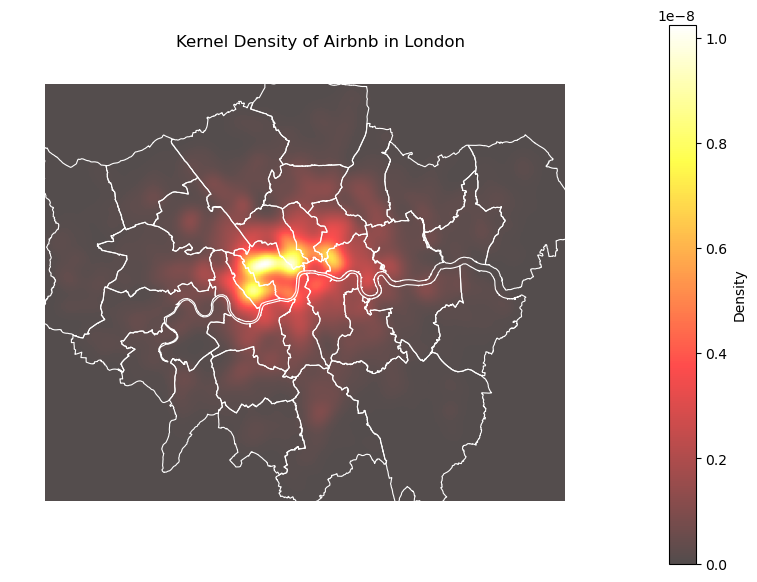

In [34]:
#plot the KDE
plt.figure(figsize=(10, 7))
plt.imshow(z,origin='lower',extent=(x_min, x_max, y_min, y_max),cmap='hot',alpha=0.7)#I think brighter is easier to see.

#Because only KDE is hard to analysis, we add London boundary onto it.
boroughs.to_crs(epsg=27700).boundary.plot(ax=plt.gca(),color='white',linewidth=0.8)

plt.title("Kernel Density of Airbnb in London")
plt.colorbar(label='Density')
plt.axis('off')
plt.show()


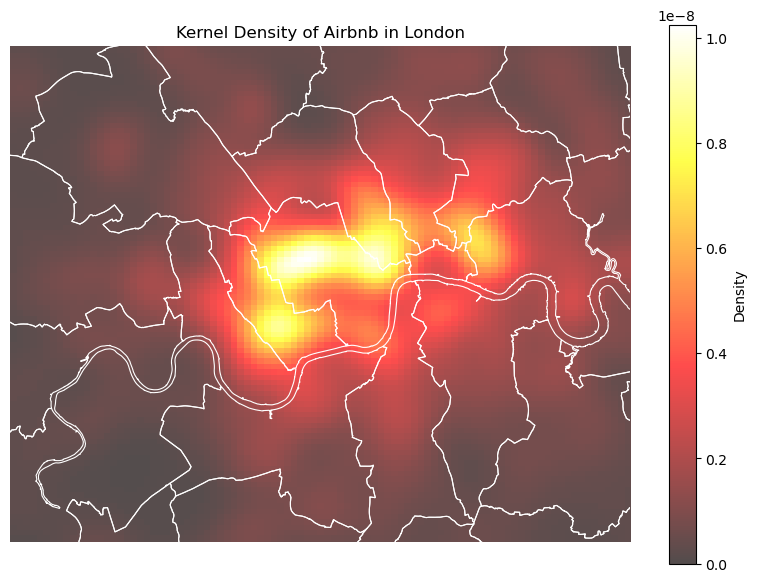

In [35]:
plt.figure(figsize=(10, 7))
plt.imshow(z,origin='lower',extent=(x_min, x_max, y_min, y_max),cmap='hot',alpha=0.7)
boroughs.to_crs(epsg=27700).boundary.plot(ax=plt.gca(),color='white',linewidth=0.8)
#Above code is same with the code in the upper chunk

#I zoom into the city centre this time
plt.xlim(515000, 540000)
plt.ylim(170000, 190000)


plt.title("Kernel Density of Airbnb in London")
plt.colorbar(label='Density')
plt.axis('off')
plt.show()


**Conclusion**

Overall, the KDE analysis shows that Airbnb in London is not uniformly spread out. Instead, it is mostly in the city center which is the location that is most affected by changes in the property market. This situation reinforces our conclusion that Airbnb activity in London is showing signs of being "out of control," as not only are there violations of the 90-day rule but also a systematic spatial pattern in which high-value areas have been taken over by intensive Airbnb operations. This pattern aligns with international research (including @barron_effect_2021) showing that Airbnb density in city centers is associated with increased rental prices and the conversion of residential units to short-term rentals.

**Limitation**

We recognise that KDE results are sensitive to bandwidth choice and do not directly measure occupancy or displacement. However, the robustness of the central-city clustering across multiple indicators, such as density, availability, and price. This gives us confidence that the observed spatial patterns reflect genuine structural dynamics rather than modelling artefacts.


In [36]:
as_markdown("1.4 Airbnb Distribution","This map provides a descriptive overview of the spatial concentration of Airbnb listings across London boroughs. While it does not constitute a formal hotspot analysis, the strong visual clustering suggests that Airbnb activity is highly uneven and concentrated in specific inner-city areas.")

##### 1.4 Airbnb Distribution

>This map provides a descriptive overview of the spatial concentration of Airbnb listings across London boroughs. While it does not constitute a formal hotspot analysis, the strong visual clustering suggests that Airbnb activity is highly uneven and concentrated in specific inner-city areas.


**Assumption**

To further assess whether Airbnb activity in London is “out of control,” we examine its borough-level concentration and the frequency of multi-listers which we defined as hosts operating more than two listings. We use multi-lister share as a proxy for professionalisation, under the assumption that managing multiple properties simultaneously requires capital, operational capacity, and a business-oriented model rather than casual home-sharing.


In [37]:
gdf_la = gpd.sjoin(
    gdf_listings,
    boroughs[["NAME", "geometry"]],
    predicate="within",
    how="left"
)

# check it
gdf_la[["id", "NAME"]].head()

/var/folders/jn/5t3xdnln3szg1qhmjj7q89sw0000gn/T/ipykernel_61775/3828514820.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...
Right CRS: EPSG:27700

  gdf_la = gpd.sjoin(


,id,NAME
0,264776,Lewisham
1,264777,Lewisham
2,264778,Lewisham
3,264779,Lewisham
4,264780,Lewisham


In [38]:
borough_stats = (
    gdf_la.groupby('NAME')
          .agg(
              total_listings=('id', 'nunique'),
              multi_lister_share=(
                  'host_total_listings_count',
                  lambda x: (x > 2).mean()
              )
          )
          .sort_values('total_listings', ascending=False)
)

borough_stats

,total_listings,multi_lister_share
NAME,,
Westminster,8347,0.844136
Kensington and Chelsea,4697,0.802427
Camden,4473,0.779119
Tower Hamlets,4414,0.715904
Southwark,3211,0.609779
Hackney,3126,0.528471
Lambeth,2926,0.568353
Wandsworth,2901,0.526715
Islington,2737,0.633906


/var/folders/jn/5t3xdnln3szg1qhmjj7q89sw0000gn/T/ipykernel_61775/920861706.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_boroughs.index, rotation=45, ha='right')


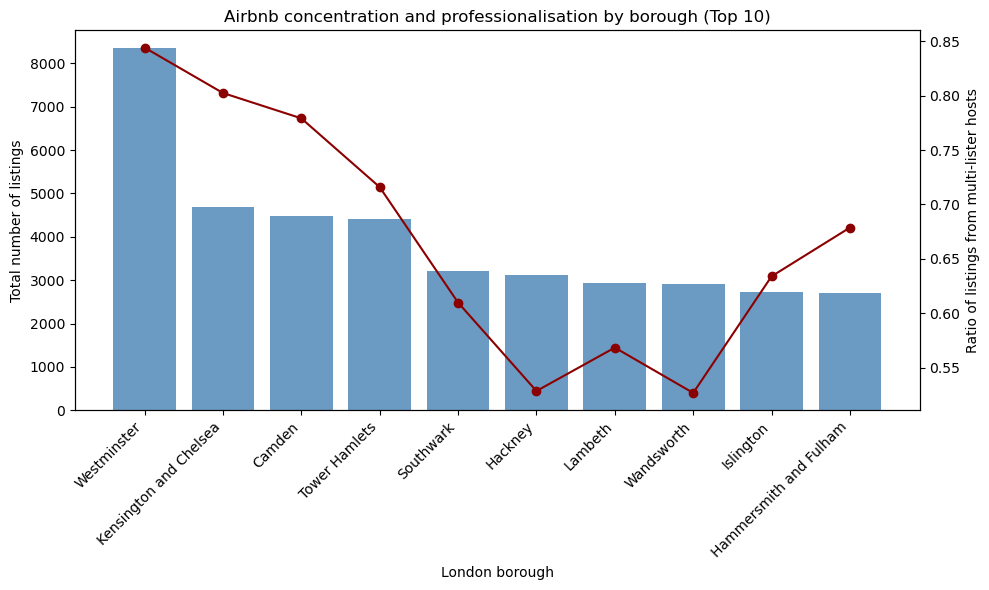

In [39]:
# Select top 10 boroughs by total listings
top_boroughs = borough_stats.head(10)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot: total listings
ax1.bar(
    top_boroughs.index,
    top_boroughs['total_listings'],
    color='steelblue',
    alpha=0.8
)
ax1.set_ylabel('Total number of listings')
ax1.set_xlabel('London borough')
ax1.set_xticklabels(top_boroughs.index, rotation=45, ha='right')

# Line plot: share of multi-lister hosts
ax2 = ax1.twinx()
ax2.plot(
    top_boroughs.index,
    top_boroughs['multi_lister_share'],
    color='darkred',
    marker='o'
)
ax2.set_ylabel('Ratio of listings from multi-lister hosts')

plt.title('Airbnb concentration and professionalisation by borough (Top 10)')
plt.tight_layout()
plt.show()

#Boroughs with the highest number of Airbnb listings also tend to have higher ratio of multi-lister hosts, suggesting that spatial concentration and professionalisation often happen at the same time.

Westminster had the most listings with 8,347. Kensington and Chelsea (4,697), Camden (4,473), and Tower Hamlets (4,414) were next. Because a lot of tourists come to these boroughs, there is a lot of demand for housing and property prices are some of the highest in London. The large concentration of listings in these areas confirms that Airbnb is highly localized, not a city-wide phenomenon.


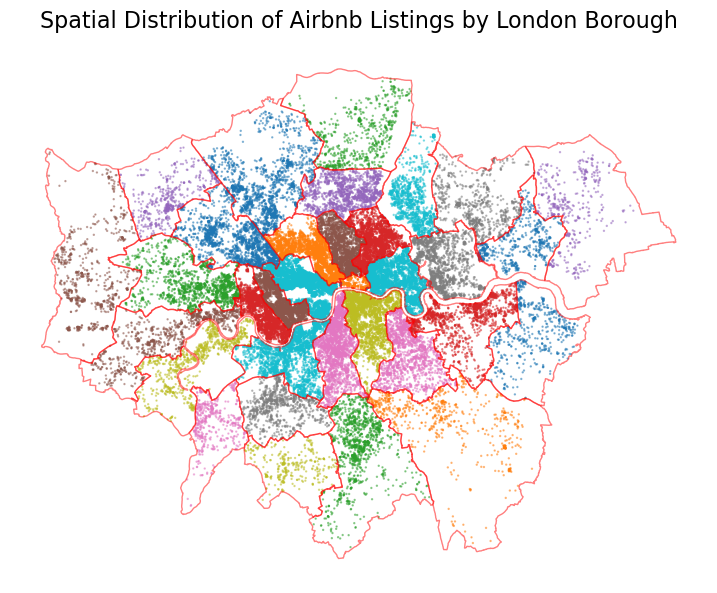

In [40]:
fig, ax = plt.subplots(figsize=(9,7))

# Click to color the name Borough
gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, ax=ax)

# Borough boundary
boroughs.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5)

ax.set_title(
    "Spatial Distribution of Airbnb Listings by London Borough",
    fontsize=16,
    pad=12
)

ax.set_axis_off()
plt.show()

We also calculated the multi-lister share, which is the proportion of hosts who have more than two listings. This indicator shows the level of Airbnb's commercialization within a borough. The results are striking: the boroughs with the highest total listings also have the highest multi-listing rates. For example, Westminster recorded a multi-listing share of 84%, followed by Kensington and Chelsea (80%) and Camden (77%). These figures indicate that the majority of listings in London's core areas are not managed by home hosts but rather by professional operators operating multiple units, which indicates a large-scale short-term rental business model.

**Conclusion**

Overall, Central and Western London boroughs are were most of the dense clusters are, while suburban boroughs tend to have lower densities (@shabrina_airbnb_2022). In other words, we found that the Airbnb-related crisis was not city-wide, but concentrated in a few strategic hotspots that played a large role in reducing the availability of long-term housing and increasing price pressures in central London. So, from the borough-level analysis demonstrates that Airbnb in London exhibits characteristics of being “out of control” in a spatially concentrated and professionalised manner. 

**Limitation**

We acknowledge that the “more than two listings” threshold may undercount professional operators who distribute properties across platforms or corporate structures. However, even under this conservative definition, the extremely high multi-lister shares observed in central boroughs provide strong evidence of systematic professionalisation.


In [41]:
as_markdown("1.5 MSOA-Level Airbnb Activity in Westminster","As shown in the map above, Westminster has the highest concentration of listings, so we chose this area for a more detailed MSOA-Level Airbnb Activity analysis. ")

##### 1.5 MSOA-Level Airbnb Activity in Westminster

>As shown in the map above, Westminster has the highest concentration of listings, so we chose this area for a more detailed MSOA-Level Airbnb Activity analysis. 


**Assumption**

 We conducted a more detailed analysis, focusing on the borough of Westminster, the area with the highest number of Airbnb listings in all of London. The aim of this analysis was to understand whether the “out of control” pattern is limited to the borough as a whole, or whether the concentration is even stronger when viewed at a smaller spatial level, namely Middle Layer Super Output Areas (MSOAs). By performing geometric clipping specifically for Westminster and then spatially joining the listing points and MSOA polygons, we were able to precisely calculate the number of listings in each MSOA.


In [42]:
#Only take the Borough polygon from Westminster.
LA = "Westminster"
west_boro = boroughs[boroughs["NAME"] == LA].copy()
print("Westminster polygon number:", len(west_boro))

#Use Westminster polygon to crop MSOA (only keep MSOAs in Westminster).
msoa_west = gpd.clip(msoa, west_boro)
print("The number of MSOA in Westminster:", len(msoa_west))

pts_west_msoa = gpd.sjoin(
    gdf_listings,
    msoa_west[["MSOA11CD", "MSOA11NM", "geometry"]],
    predicate="within",
    how="inner"     # just need the spots in MSOA
)
print("The number of listings in Westminster:", len(pts_west_msoa))

#Statistics by MSOA: How many listings are there per MSOA?
msoa_stats = (
    pts_west_msoa
      .groupby(["MSOA11CD", "MSOA11NM"])
      .size()
      .reset_index(name="listing_count")
)
print("\nExample of MSOA statistics in Westminster：")
print(msoa_stats.head())

#Merge listing_count back into Westminster's MSOA polygon
msoa_west_counts = msoa_west.merge(
    msoa_stats,
    on=["MSOA11CD", "MSOA11NM"],
    how="left"
)

#For MSOA without a listing, enter 0.
msoa_west_counts["listing_count"] = msoa_west_counts["listing_count"].fillna(0)

#Convert to Web Mercator for overlaying background images
msoa_west_3857 = msoa_west_counts.to_crs(epsg=3857)


Westminster polygon number: 1
The number of MSOA in Westminster: 41
The number of listings in Westminster: 8345

Example of MSOA statistics in Westminster：
    MSOA11CD                    MSOA11NM  listing_count
0  E02000124                   Brent 032              2
1  E02000126                   Brent 034              3
2  E02000191                  Camden 026              5
3  E02000193                  Camden 028              2
4  E02000588  Kensington and Chelsea 012              1


/var/folders/jn/5t3xdnln3szg1qhmjj7q89sw0000gn/T/ipykernel_61775/234072020.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...
Right CRS: EPSG:27700

  msoa_west = gpd.clip(msoa, west_boro)


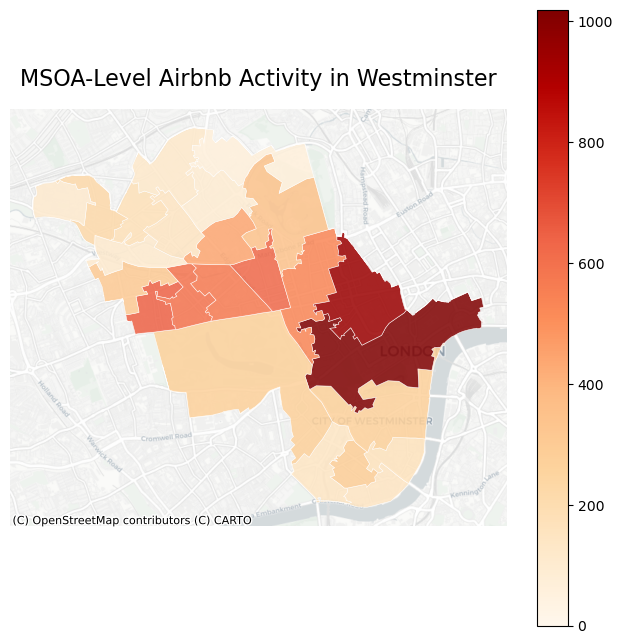

In [43]:
#plot：MSOA-Level Airbnb Activity in Westminster
fig, ax = plt.subplots(figsize=(8, 8))
msoa_west_3857.plot(
    column="listing_count",
    cmap="OrRd",
    linewidth=0.4,
    edgecolor="white",
    legend=True,
    ax=ax,
    alpha=0.85
)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title("MSOA-Level Airbnb Activity in Westminster", fontsize=16)
plt.show()

The analysis revealed a total of 8,345 Airbnb listings in Westminster, a figure that confirms the borough's dominance as a major hotspot for short-term rental activity. However, the distribution is uneven within Westminster. The map shows that several MSOAs in the east and southeast of Westminster have very high Airbnb intensity, some with over 1,000 listings in a single MSOA. These areas include the areas around Covent Garden, Soho, Leicester Square, and Victoria, areas that boast a unique combination of tourist attractions, major transport stations, and very high commercial density.


In contrast, MSOAs located in the western half of Westminster, such as districts surrounding Maida Vale or St John's Wood exhibit much lower listing counts which indicates  that Airbnb is not only concentrated within the borough of Westminster, but also concentrated in specific pockets within it. In other words, the problem of short-term rentals, potentially violating the 90-day regulation and encouraging property commercialization, occurs in these super-dense zones, which cover only a small portion of Westminster but have a significant impact on the local housing market.

**Conclusion**

This MSOA analysis reinforces the conclusion that Airbnb in London, particularly in Westminster is showing very clear signs of being “out of control.” Even within a single borough, there are areas with such high listing levels that they likely operate more like informal hotels than simply home-sharing platforms. Furthermore, the extreme centralization pattern we found at the MSOA level is consistent with the findings of @shabrina_airbnb_2022, which explains that Airbnb abuse is most intense in locations with high tourism demand and high housing pressure.
 

**Limitation**

We acknowledge that this MSOA-level analysis focuses exclusively on Westminster, the borough with the highest Airbnb concentration, and therefore may not be representative of intra-borough patterns elsewhere in London. In addition, MSOA-level counts capture the number of listings rather than actual occupancy or frequency of use, meaning that high listing density does not necessarily imply continuous activity or regulatory non-compliance. Finally, while MSOAs provide finer spatial resolution than boroughs, they may still mask variation within very small neighbourhoods or individual buildings, particularly in areas with dense mixed-use development.


In [44]:
as_markdown("1.6 MSOA-level CLustering","To identify the spatial types of Airbnb activities in London, we selected three variables at the MSOA level to do clustering.")

##### 1.6 MSOA-level CLustering

>To identify the spatial types of Airbnb activities in London, we selected three variables at the MSOA level to do clustering.


**Assumption**

We assume that the three selected variables, such as listing count, average price, and the share of listings exceeding 90 days represent the fundamental aspect of Airbnb intensity and commercialisation at the neighbourhood level. We also assume that k-means clustering with three clusters provides us a useful and understanable way to group Airbnb activity, balancing analytical simplicity with sufficient differentiation across MSOAs.

In [45]:
#features for clustering
features = msoa_stats_q1[['ratio_over_90', 'n_listings', 'mean_price']].copy()
# Replace missing values with 0
features = features.fillna(0)
features.describe()


,ratio_over_90,n_listings,mean_price
count,982.000000,982.000000,982.000000
mean,0.763689,63.575356,135.155343
std,0.114638,91.021152,59.115535
min,0.428571,1.000000,35.666667
25%,0.682301,17.000000,98.985248
50%,0.756991,35.000000,121.850473
75%,0.834420,74.000000,158.881612
max,1.000000,1019.000000,573.697080


In [46]:
#Because there is a large difference between the value of those three variables, 
#we need to do a standardisation.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


In [47]:
#Use KMeans as the clustering method
kmeans = KMeans(n_clusters=3, random_state=42,n_init=10)#I choose 3 because it's not that large or small
clusters = kmeans.fit_predict(X_scaled)

msoa_stats_q1['cluster'] = clusters
msoa_stats_q1['cluster'].value_counts()

cluster
2    521
1    401
0     60
Name: count, dtype: int64

In [48]:
#Comparing mean value of cluster for those three variables.
cluster_profile = (msoa_stats_q1.groupby('cluster')[['ratio_over_90', 'n_listings', 'mean_price']].mean().round(3))

cluster_profile

,ratio_over_90,n_listings,mean_price
cluster,,,
0,0.755,327.000,279.299
1,0.871,26.928,110.251
2,0.682,61.445,137.724


In [49]:
#add a lable to cluster
cluster_labels = {
    0: "High Airbnb represent areas",
    1: "Moderate Airbnb activity areas",
    2: "Low Airbnb presence areas"
}

msoa_stats_q1['cluster_label'] = msoa_stats_q1['cluster'].map(cluster_labels)

In [50]:
#keep only geometry and identifier for mapping
msoa_min=msoa[['MSOA11CD','MSOA11NM','geometry']].copy()
#attach cluster labels to msoa
msoa_stats_q1['cluster']=clusters

In [51]:
type(msoa_1)

geopandas.geodataframe.GeoDataFrame

In [52]:
#merge cluster results back onto msoa polygon
msoa_ready=msoa_min.merge(msoa_stats_q1,on='MSOA11CD',how='left')

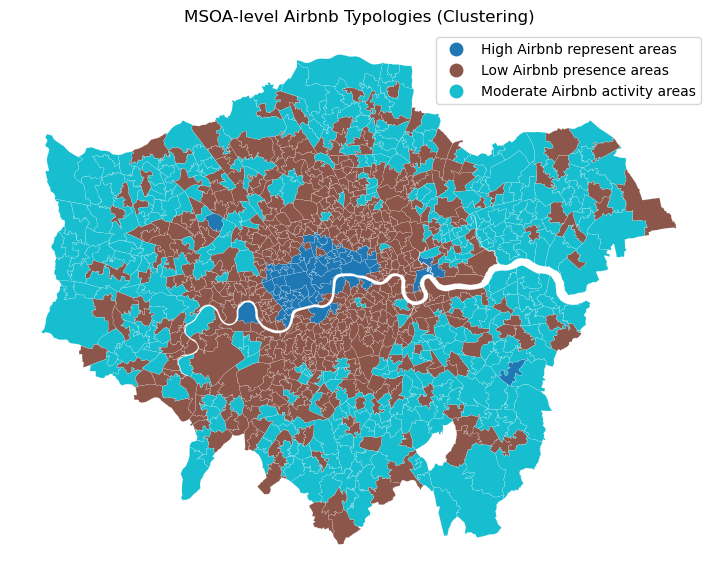

In [53]:
#Plot a graph of MSOA-level Airbnb area types based on clustering.
fig, ax = plt.subplots(figsize=(10,7))

msoa_ready.plot(
    column='cluster_label',
    categorical=True,
    legend=True,
    ax=ax,
    linewidth=0.1,
    edgecolor='white'
)

ax.set_axis_off()
ax.set_title("MSOA-level Airbnb Typologies (Clustering)")
plt.show()


The k-means clustering results yield three distinct Airbnb area types. The highest-intensity cluster is characterized by a combination of a very large number of listings, high average prices, and significant violations of the 90-day rule which strongly concentrated in Central London. In this context, our clustering provides additional evidence that the phenomenon is not only evident at the borough level but also structured down to the neighborhood scale (MSOA).

The second cluster exhibits a different, but still problematic, pattern. Although the number of listings and average prices are lower than those in the intensive cluster, areas within this cluster have the highest proportion of listings >90 days. This suggests that in semi-residential areas, Airbnb operates more “invisibly” as a sustainable short-term rental, though not always at a large scale or at premium prices. This pattern supports what Barron et al. (2021) said that Airbnb has the biggest effect on the housing market when residential units are switched from the long-term to the short-term rental market, no matter where they are. 

By contrast, the low-intensity cluster includes the majority of London’s suburban MSOAs, characterised by fewer listings, more moderate prices, and lower rates of 90-day exceedance. This cluster most closely reflects the original home-sharing model of Airbnb and indicates that “out of control” dynamics are not present uniformly across the city.


**Conclusion**

The MSOA-level clustering confirms that Airbnb in London is not only concentrated in certain areas but also work differently indifferent neihborhoods. High- and medium-intensity clusters show where Airbnb is most likely to be a long-term business, which could affect the availability of housing and the stability ofneighboorhoods. These results support the idea that policies should be tailored to certain areas and have diverse structures, rather than being the same for the whole city.
 

**Limitation**

We acknowledge that the clustering results are sensitive to the choice of variables and the number of clusters, and alternative specifications could yield slightly different typologies. In addition, MSOA-level aggregation may mask variation within smaller neighbourhoods or individual buildings, particularly in dense mixed-use areas. Finally, the analysis relies on listing characteristics rather than direct measures of occupancy or profitability, meaning that cluster membership reflects potential intensity of use rather than confirmed regulatory non-compliance.

### 1.7 Overall Conclusion

Based on the overall analysis of 1.1–1.6, we conclude that Airbnb in London exhibits a spatially and structurally “out-of-control” situation, although not uniformly across the city. Airbnb’s regulatory overreach, combined with high prices, extreme density in the city center, and the dominance of professional hosts, suggests that the platform has shifted from a home-sharing model to a commercialized short-term rental operation. 

# 2. How many professional landlords are there?
To assess whether Airbnb in London is experiencing "over control", we may say a host with multiple renting houses are over-commercialisation is causing over control. So start with analyzed the number of listings available from each host.

Ratio of hosts with >2 listings: 65.10%


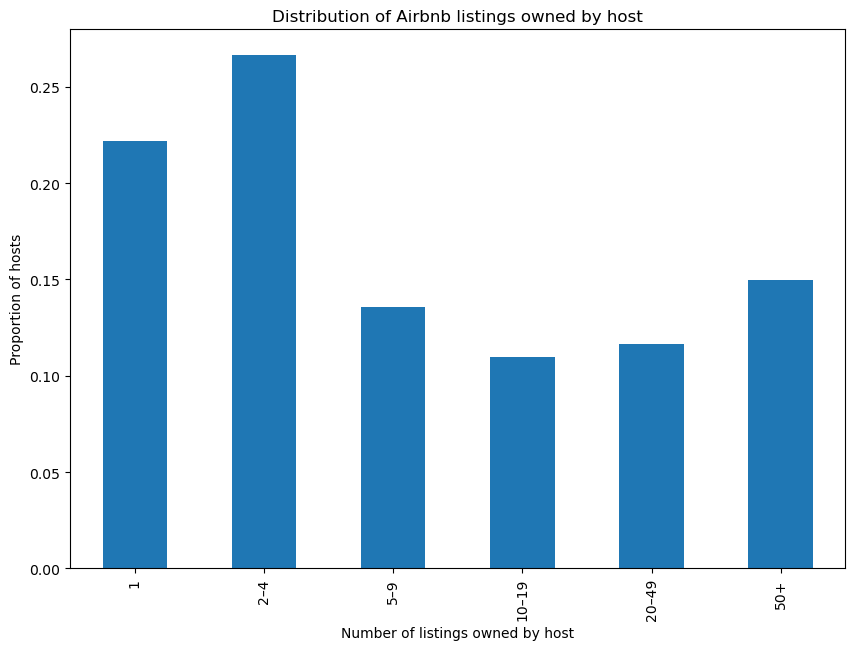

In [54]:
#calculate proportion of hosts with more than 2 listings
host_counts = df['host_total_listings_count']
multiratio = (host_counts > 2).mean()
print(f"Ratio of hosts with >2 listings: {multiratio:.2%}")

#Define bin and labels（menas how houses many a host renting)
bins = [0, 1, 4, 9, 19, 49, 999]
labels = ["1", "2–4", "5–9", "10–19", "20–49", "50+"]

# Create categorical bin column
df['host_bin'] = pd.cut(host_counts, bins=bins, labels=labels)
# Compute the ratio of hosts
dist = (df['host_bin'].value_counts(normalize=True).sort_index())
#plot
ax = dist.plot(kind='bar', figsize=(10, 7))
ax.set_xlabel("Number of listings owned by host")
ax.set_ylabel("Proportion of hosts")
ax.set_title("Distribution of Airbnb listings owned by host")
plt.show()

In [55]:
#proportion of hosts with > 2 listings
host_level = df.groupby('host_id')['host_total_listings_count'].max()
multi_host_share = (host_level > 2).mean()
print(f"Proportion of multi-lister hosts (>2 listings): {multi_host_share:.2%}")

#proportion of listings owned by multi-listers
listing_multi_share = (df['host_total_listings_count'] > 2).mean()
print(f"Proportion of listings owned by multi-listers: {listing_multi_share:.2%}")


Proportion of multi-lister hosts (>2 listings): 35.02%
Proportion of listings owned by multi-listers: 65.10%


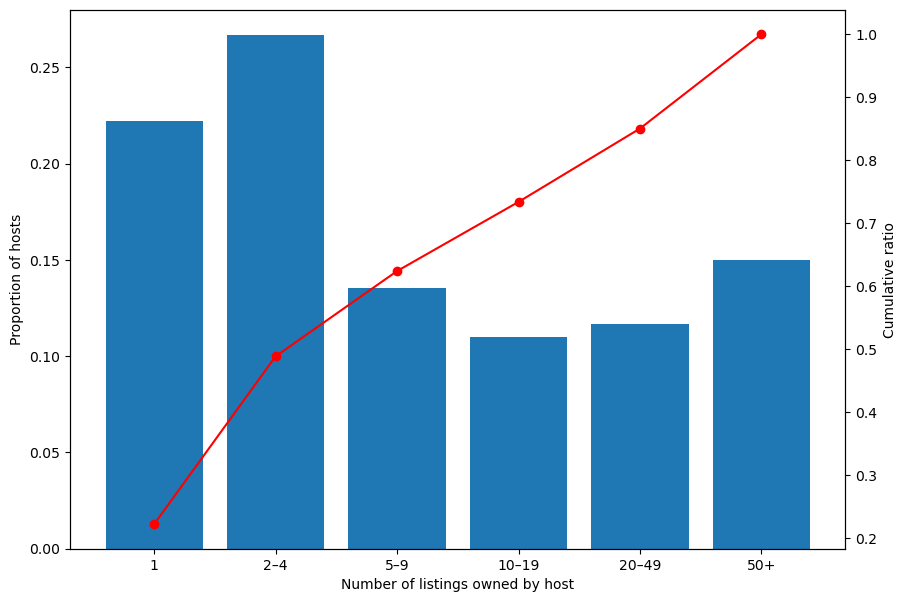

Cumulative share by bin:
host_bin
1        22.19%
2–4      48.85%
5–9      62.39%
10–19    73.37%
20–49    85.02%
50+      100.0%
Name: proportion, dtype: object


In [56]:
#Make a cumulative distribution
#compute cumulative ratio across host-size bins
cum = dist.cumsum()
#graph fitting
fig, ax1 = plt.subplots(figsize=(10, 7))
# Plot a same graph above
ax1.bar(dist.index, dist.values, label="Bin share")
ax1.set_xlabel("Number of listings owned by host")
ax1.set_ylabel("Proportion of hosts")
#Create another axis for cumulative line plot
ax2 = ax1.twinx()
ax2.plot(cum.index, cum.values, color="red", marker="o", label="Cumulative ratio")
ax2.set_ylabel("Cumulative ratio")
plt.show()
#Print cumulative ratio values
print("Cumulative share by bin:")
print((cum * 100).round(2).astype(str) + "%")


# 3.How many properties would be affected by the opposition’s proposal?
To determine the number of properties affected, we first need to filter out professional landlords, as the opposition proposal only applies to them. Secondly, the extent to which professional landlords are affected depends on the number of properties they own. Therefore, we can assess the degree of impact by counting the number of properties owned by different professional landlords.

as_markdown("3.1","A bar chart showing the distribution of affected listings by region")

In [57]:
#How many hosts are affected
affected_hosts = df[df['host_total_listings_count'] > 2]['host_id'].nunique()
total_hosts = df['host_id'].nunique()

affected_host_ratio = affected_hosts / total_hosts

print(f"There are {affected_hosts} hosts were impacted，which is {affected_host_ratio:.0%} of total.")

There are 10889 hosts were impacted，which is 35% of total.


In [58]:
#Find all professional landlords' host_id
pro_hosts = df[df['host_total_listings_count'] > 2]['host_id'].unique()
#Filter all listings under these landlords' names
affected_properties = df[df['host_id'].isin(pro_hosts)]
#Calculate the number of affected properties
n_affected = len(affected_properties)
#Compared to the entire Airbnb market
total_listings = len(df)
affected_ratio = n_affected / total_listings

print(f"There are {n_affected} listings were impacted，which is {affected_ratio:.0%} of total.")

There are 40651 listings were impacted，which is 65% of total.


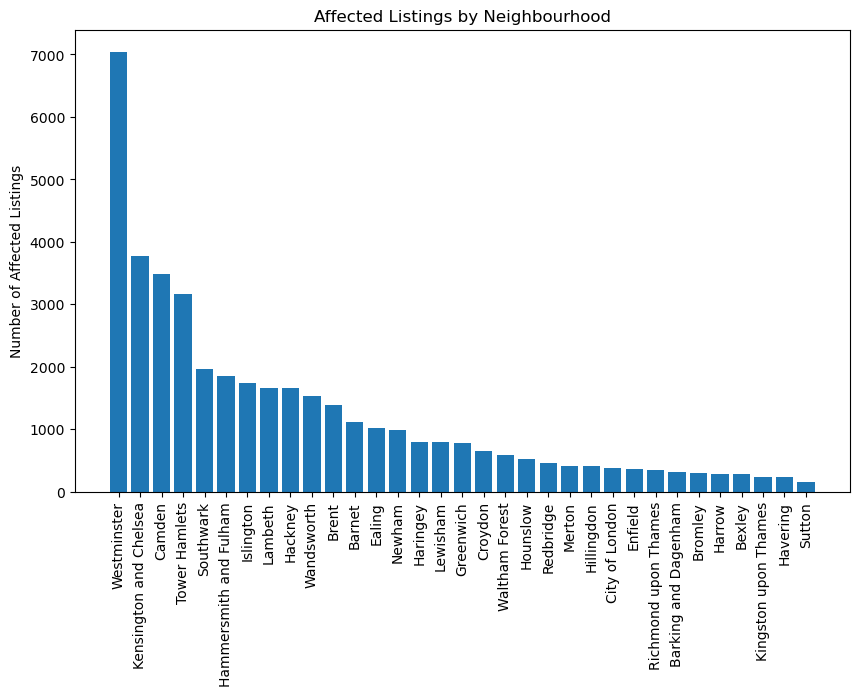

In [59]:
affected_by_area = (
    affected_properties.groupby('neighbourhood_cleansed')
                       .size()
                       .reset_index(name='n_affected')
                       .sort_values('n_affected', ascending=False)
)

plt.figure(figsize=(10,6))
plt.bar(affected_by_area['neighbourhood_cleansed'], affected_by_area['n_affected'])
plt.xticks(rotation=90)
plt.ylabel('Number of Affected Listings')
plt.title('Affected Listings by Neighbourhood')
plt.show()

as_markdown("3.2","Display the location of professional landlord listings on a map")

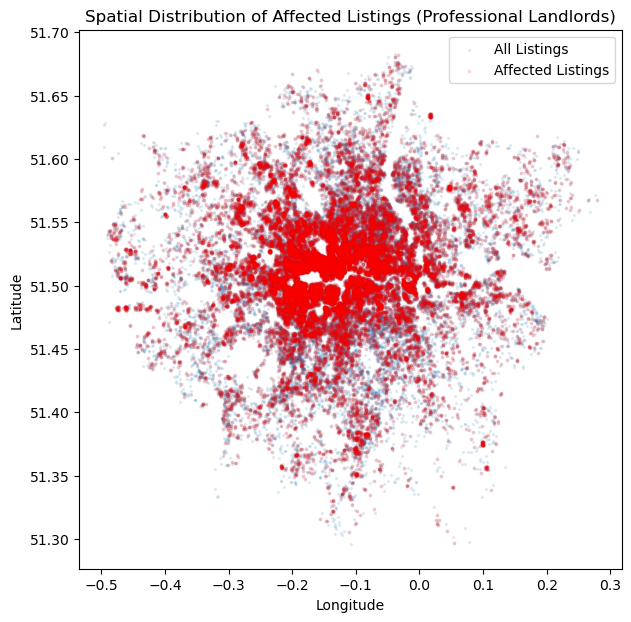

In [60]:
plt.figure(figsize=(7,7))
plt.scatter(df['longitude'], df['latitude'], s=2, alpha=0.1, label='All Listings')
plt.scatter(affected_properties['longitude'], affected_properties['latitude'], s=4, color='red', alpha=0.1, label='Affected Listings')

plt.legend()
plt.title('Spatial Distribution of Affected Listings (Professional Landlords)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Affected Proportion Map

In [61]:
#affected listings
df['affected'] = df['host_total_listings_count'] > 2

#Bring into spatial data
affected_gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude, df.latitude),crs="EPSG:4326").to_crs(msoa.crs)
#Spatial join to MSOA
affected_msoa = gpd.sjoin(affected_gdf,msoa[['MSOA11CD', 'geometry']],how='left',predicate='within')
#aggregate by MSOA
msoa_affected_stats = (affected_msoa.groupby('MSOA11CD').agg(total_listings=('id', 'count'),affected_share=('affected', 'mean')).reset_index())

# Merge back to MSOA polygons
msoa_affected_map = msoa.merge(msoa_affected_stats,on='MSOA11CD',how='left')
msoa_affected_map['affected_share'] = msoa_affected_map['affected_share'].fillna(0)


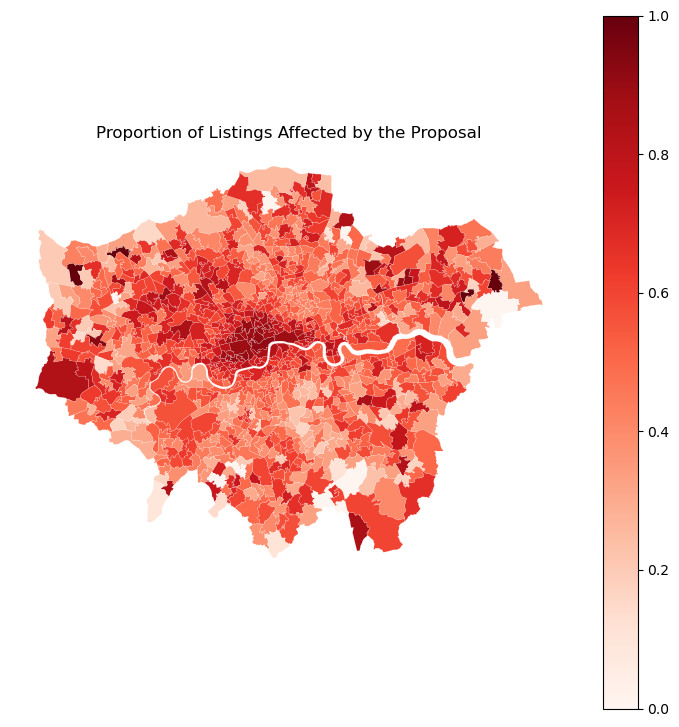

In [62]:
fig, ax = plt.subplots(figsize=(9,9))

msoa_affected_map.plot(
    column='affected_share',
    cmap='Reds',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

ax.set_title("Proportion of Listings Affected by the Proposal")
ax.set_axis_off()
plt.show()

## 4. What are the likely pros and cons of the opposition’s proposal (for the Mayor, for residents, and for the city)?


<p style="text-align: justify;">
The following policy interpretation builds on empirical results from Q1–Q3. Our analysis shows that London's Airbnb market is dominated by professional activity and concentrated in the central boroughs. Therefore, we believe this opposition proposal should be understood not simply as a short-term political response, but as an attempt to intervene in the city's housing and tourism market structure.
</p>


### 4.1  Implication for Mayor

#### 4.1.1 Pros

For the Mayor, a regulatory policy centered on professional Airbnb operators is a direct consequence of the empirical trends observed in Questions 1–3, indicating that Airbnb-related pressures in London are significantly concentrated, financially motivated, and spatially inconsistent. Rather than being distributed across the city as a whole, these pressures are primarily generated by a relatively small group of professional landlords operating large-scale short-term rental businesses in central boroughs. The mayor can rightfully say that the policy is founded on evidence, fair, and focused by using a different set of rules that separates casual home-sharing from short-term rental for business purposes. This approach reflects best practices highlighted in the urban planning literature, which emphasizes the importance of actor difference in Airbnb regulation (@gurran_when_2017).

This kind of framework also provides the mayor a solid reason to ask commercial short-term rentals to pay more taxes. As shown in Q2 and Q3, most of the listings on Airbnb are owned by professional landlords, and most of the activity happens in locations where infrastructure, public services, and community amenities are most stressed. Higher Council Tax rates or targeted taxes on particular properties can therefore be justified as a way to internalize external expenses, rather than as a general tax increase. If revenues are clearly reinvested in affected neighborhoods, the mayor can increase the credibility of the strategy. 
Politically, this strategy enables the mayor to directly address the geography of impact indicated in Q1-Q3. Residents in central London neighborhoods are particularly affected by Airbnb activity, such as noise, housing pressure, and high turnover of occupants. A targeted regulatory response enables the mayor to demonstrate responsiveness to these lived realities, reinforcing political credibility in areas where dissatisfaction is most intense.


#### 4.1.2 Cons

This method also has political and institutional concern at the same time.   We can see from Questions 2 and 3 that a lot of Airbnb rentals are owned by professional landlords. This offers them a lot of reasons and resources to fight against rules. According to @barron_effect_2021, he claims that large-scale short-term rental operators are often the most active opponents of regulation intervention. They using lobbying, media framing, and legal challenges to defend their interests.  To deal with this resistance, the mayor would need to be careful with the communication and robust legal design.
There is also a risk related to policy framing in an electoral context. If people think that the mayor’s response is a direct adoption of an opposition plan, instead of a separate policy based on independent analysis, it may seem more like a reaction than a strategy. To mitigate this risk, the mayor would need to make it clear how the empirical data in Questions 1-3 has formed the regulatory framework and how it is different from blanket or symbolic intervention.



### 4.2 Implication for Residents 

#### 4.2.1 Pros 

The proposed regulatory strategy could make housing more available and enhance neighborhood conditions for inhabitants, especially those who live in central boroughs. More than half of the Airbnb listings in London are run by professional landlords, and many them run houses almost all the time, as shown in Question 3. If this part of the market is regulated, it may make is less appealing to keep properties as full-time short-term rentals. This would make it more likely that some units would go back to the long-term rental market.  Evidence indicates that regulations are impossible to provide substantial rent decrease citywide, nonetheless, they may alleviate pressure in neighborhoods where Airbnb has significantly reduced long-term housing availability (@garcia-lopez_short-term_2020).

Residents may also benefit from a more stable and higher quality of life. Airbnb activity is very clustered as shown in Question 1. This means that short-term guests often leave and come back to the same places. @gurran_when_2017 link these types of patterns to more noise, less social cohesion, and a lower quality of life in neighborhoods. So, even if it's hard to put value on how much better life would be if there were fewer short-term business leases, it might be worth it.  

In addition, the regulatory strategy might assist stop gentrification and displacement caused by tourist. @shabrina_airbnb_2022 explains that Airbnb is being misused in London mostly in areas with a lot of tourist and private rental homes.  This is turning residential neighborhoods into quasi-tourist zones. Regulation that focused on certain areas could assist by giving people less opportunities to guess.  




#### 4.2.2 Cons

Residents may also have to face trade-offs. Airbnb is not only for tourists, buti it also for students, transient workers, and families that are moving and require flexible short-term housing. These options may be difficult ro uncover if there are fewer professional Airbnb listings, especially in central boroughs that are easy to access.  

There is also a risk of cost shifting rather than cost reduction. @garcia-lopez_short-term_2020 note that if there are limits on Airbnb, people would look for hotels or serviced apartments instead, which could drive up prices in such markets. These effects may disproportionately impact on middle-income users who used to use Airbnb because it was a reasonable cheap option.

Finally, the benefits of regulation are likely unevenly distributed. As shown in Questions 1–3, Airbnb impacts are spatially concentrated, meaning residents in outer boroughs may see little direct improvement while still experiencing indirect effects, such as higher short-term accommodation costs. This uneven geography raises questions of distributional fairness (@shabrina_airbnb_2022).


### 4.3 Implication for City

#### 4.3.1 Pros

At the city scale, a focused regulatory framework has the potential to improve the general functioning of London's housing market by addressing the reallocation of properties to short-term rental use identified in Question 1 and 3. Limiting large-scale commercial Airbnb activity can reduce upward pressure on rents and house prices in impacted areas, especially where short-term rentals replace long-term housing (@garcia-lopez_short-term_2020).
The framework would also enhance urban governance capacities. A registration requirement would provide more accurate data about the size and location of short-term rental activity. This would let governance to make laws that more flexible and more suited to each area.
According to @gurran_when_2017, effective Airbnb regulation needs information, the power of enforce regulations, and clear rules. In addition, reducing high-density Airbnb clusters in central boroughs may assist to mitigate some of the negative overtourism, such as demand on infrastructure, public space, and local services. 

#### 4.3.2 Cons

Displacement effects can happen when activity moves to other boroughs, platforms, or types of housing instead of going away completely (@garcia-lopez_short-term_2020). Short-term changes may potentially affect some parts of London's tourism industry, especially among mid-range visitors who use Airbnb. Finally, given Airbnb's effects vary greatly throughout cities, applying the identical laws to all boroughs may not be an optimal option. If there is no way to tell the difference between areas and coordinate among boroughs, the rules may be overly strict in low-impact areas or inadequately tough in core hotspots. This a challenge widely noted in the urban planning literature (@gurran_when_2017).

### 4.4 Overall Positioning

Based on the data from Questions 1–3, a targeted, evidence-led regulation framework focused on professional short-term rental activity offers the mayor the greatest opportunity to deal with housing challenges caused by Airbnb while still being political credible. The benefits are clearest in central boroughs and among residents most exposed to commercial Airbnb activity, while the risks relate primarily to enforcement capacity, political resistance, and displacement effects. How the Mayor frames and differentiates this response will ultimately determine whether the policy is perceived as reactive or as a demonstration of strategic, data-driven leadership.

## 5. Can the story be reframed as a positive one about social mobility or housing opportunity?


Based on our findings from Q1–Q3, the scandal involving the ownership of multiple Airbnb properties by a single advisor does not fully represent how the majority of Airbnb hosts operate in London. Our analysis suggests that the primary issue in the Airbnb market is not the presence of small hosts renting out single units or rooms, but rather the dominance of professional landlords, who control more than half of all listings and operate intensively in central areas. These findings open space for a more balanced reframing of the Airbnb debate.

The key issue is therefore not simply the existence of Airbnb itself, but how the platform’s economic benefits are distributed and which groups benefit most from its operation.

From our perspective, Airbnb still holds potential as a source of social mobility and economic opportunity for some residents, particularly small homeowners. Many small hosts are motivated to rent out spare rooms or properties due to economic necessity, work flexibility, or the need to supplement household income by monetizing assets they already own, thereby creating additional income opportunities without entering formal employment (@arenoe_game_2015; @sundararajan_sharing_2016).

Some positive narratives that could be emphasized include:
- A London resident renting out a spare room to help cover mortgage payments or rising living costs.
- An elderly homeowner generating supplementary income through short-term rentals without having to sell their home.
- A middle-income household using Airbnb occasionally as a temporary financial support mechanism.

However, our data also indicate that this positive narrative cannot be generalized across the entire London Airbnb market. As a result, we argue that the most credible reframing strategy is not to defend Airbnb as a whole, but to clearly distinguish between genuine home-sharing and the large-scale commercialization of housing.

The city government can emphasize that the objective of regulation is not to eliminate supplementary income opportunities for small homeowners, but to limit the use of Airbnb as a vehicle for property accumulation by elite actors.

Examples of policy reframing strategies include:
- Communicating that hosts with one or two listings remain protected as part of the sharing economy, while professional operators are subject to stricter regulation.
- Framing regulation as a means of safeguarding ordinary residents’ economic opportunities from over-commercialization.
- Ensuring that Airbnb regulations do not stifle innovation, while simultaneously supporting access to long-term housing.

In this way, the Mayor can reframe the controversy as part of a broader commitment to innovation and economic mobility that does not come at the expense of access to adequate housing. Optimistic perspectives on the sharing economy’s potential for social mobility (@arenoe_game_2015; @sundararajan_sharing_2016) can coexist with concerns about over-commercialization (@slee_whats_2015), while our empirical findings suggest that selective, targeted, and evidence-based regulation is essential for balancing these objectives in the London context.


# Reference

Bailey, N. and Minton, J. (2018) ‘The suburbanisation of poverty in British cities, 2004-16: extent, processes and nature’, Urban Geography, 39(6), pp. 892–915. doi: 10.1080/02723638.2017.1405689.

Barron, K., Kung, E., & Proserpio, D. (2020). The effect of home-sharing on house prices and rents: Evidence from Airbnb. Marketing Science, 39(6), 1141–1163. https://doi.org/10.1287/mksc.2020.1227.

Bosetti, N., Sims, S. and Travers, T. (2016). Housing and Inequality in London. [online] centreforlondon.org. Available at: https://centreforlondon.org/publication/housing-and-inequality-in-london/.

Choi, K., Jung, J., Ryu, S., & Kim, S. (2015). The motivations behind Airbnb hosting: Evidence from a survey. Tourism Management, 51, 39–51. https://doi.org/10.1016/j.tourman.2015.04.007.

García-López, M. A., Jofre-Monseny, J., Martínez-Mazza, R., & Segú, M. (2020). Do short-term rental platforms affect housing markets? Evidence from Airbnb in Barcelona. Regional Science and Urban Economics, 84, 103530. https://doi.org/10.1016/j.regsciurbeco.2020.103530.

Gurran, N., & Phibbs, P. (2017). When tourists move in: How should urban planners respond to Airbnb? Journal of the American Planning Association, 83(1), 80–92. https://doi.org/10.1080/01944363.2016.1249011.

Slee, T. (2017). What’s yours is mine: Against the sharing economy. London: Verso Books.

Shabrina, Z., Buyuklieva, B., & Pettit, C. (2021). Airbnb and its potential impact on the London housing market. Cities, 115, 103243. https://doi.org/10.1016/j.cities.2021.103243

Sundararajan, A. (2016). The sharing economy: The end of employment and the rise of crowd-based capitalism. Cambridge, MA: MIT Press.